# Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

# Device Setting

In [2]:
# Device configuration
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
print('device:', device)

device: cuda


# Step 1) Generate Function

In [3]:
def f(x, y):
  return np.sin(20*np.sqrt(x**2+y**2))/(20*np.sqrt(x**2+y**2)) + np.cos(10*np.sqrt(x**2+y**2))/5 + y/2 - 0.3

# Step 2) Generate Data

In [4]:
x = np.linspace(start=-1, stop=1, num=100)
y = np.linspace(start=-1, stop=1, num=100)

x_, y_ = np.meshgrid(x, y)

sample_data = np.hstack((x_.reshape(-1, 1), y_.reshape(-1, 1)))
target_data = f(sample_data[:,0], sample_data[:,1]).reshape(-1, 1)

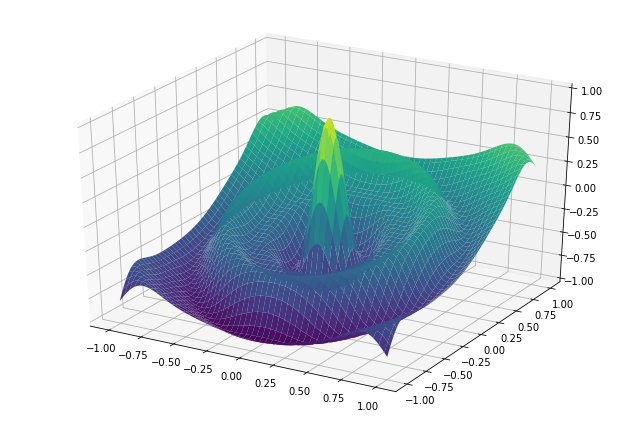

In [5]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x_, y_, f(x_, y_), cmap='viridis')
surf.set_clim(-1.0, 1.0)
ax.view_init(30,-60)
ax.set_zticks([-1,1])
ax.zaxis.set_major_locator(ticker.MultipleLocator(0.25))
plt.tight_layout()
plt.show()

# Step 3) Data Split

In [6]:
# Split train data into Train/Validation_Test data
x_train, x_vt, y_train, y_vt = train_test_split(sample_data, target_data, test_size = 0.3, shuffle=True)

# Split train data into Validation/Test data
x_val, x_test, y_val, y_test = train_test_split(x_vt, y_vt, test_size = 0.5, shuffle=True)

# Check data shape
print(f"Train 데이터 크기: {x_train.shape, y_train.shape}")
print(f"Validation 데이터 크기: {x_val.shape, y_val.shape}")
print(f"Test 데이터 크기:{x_test.shape, y_test.shape}")

Train 데이터 크기: ((7000, 2), (7000, 1))
Validation 데이터 크기: ((1500, 2), (1500, 1))
Test 데이터 크기:((1500, 2), (1500, 1))


# Step 4) Data Loader

In [7]:
class Mydataset(torch.utils.data.Dataset):

    # 데이터 전처리 
    def __init__(self, dataX_np , dataY_np):
        self.data_X = dataX_np.astype(np.float32)
        self.data_Y = dataY_np.astype(np.float32) 

        print(f"My_dataset __init__ received : {self.data_X.shape}, {self.data_Y.shape} ")

    # 인덱스를 입력받아 인덱스에 알맞는 입출력 데이터를 Return
    def __getitem__(self, index):
        sample = self.data_X[index]
        target = self.data_Y[index]

        return sample, target
    
    # 총 데이터 개수를 Return
    def __len__(self):
        return len(self.data_X)

In [8]:
train_loader = torch.utils.data.DataLoader(Mydataset(x_train, y_train), batch_size=10000000, shuffle=True, drop_last=False)
valid_loader = torch.utils.data.DataLoader(Mydataset(x_val, y_val), batch_size=10000000, shuffle=True, drop_last=False)
test_loader = torch.utils.data.DataLoader(Mydataset(x_test, y_test), batch_size=10000000, shuffle=True, drop_last=False)

My_dataset __init__ received : (7000, 2), (7000, 1) 
My_dataset __init__ received : (1500, 2), (1500, 1) 
My_dataset __init__ received : (1500, 2), (1500, 1) 


# Step 5) MLP

In [9]:
class SimpleMLP(nn.Module):

  def __init__(self, inp_ = 2, output_ = 1):
    super(SimpleMLP, self).__init__()
    self.fc1 = nn.Linear(2, 32)
    self.fc2 = nn.Linear(32, 128)
    self.fc3 = nn.Linear(128, 1)

  def forward(self, x):
    x = self.fc1(x)
    x = torch.tanh(x)
    x = self.fc2(x)
    x = torch.tanh(x)
    x = self.fc3(x)

    return x

In [10]:
from statistics import mean
import time

def train(model, criterion_, optimizer_, scheduler_, num_epochs=40, first_epoch=1):

  train_losses = []
  valid_losses = []
  test_losses = []

  print("----------------------------------------------------------------------------")
  
  start_time = time.time()

  for epoch in range(first_epoch, first_epoch + num_epochs):
    
    # train phase
    model.train()
    
    # batch_loss
    batch_losses = []
  
    for sample, target in train_loader:
      
      # Move the training data to the GPU
      sample = sample.to(device)
      target = target.to(device)
      
      # clear previous gradient computation
      optimizer_.zero_grad()
      
      # forward propagation
      outputs = model(sample)
      
      # calculate the loss
      loss = criterion_.forward(outputs, target)
      batch_losses.append(loss.item())
      
      # backpropagate to compute gradients
      loss.backward()
      
      # update model weights
      optimizer_.step()
  
    # Train loss 를 저장합니다.
    train_losses.append(mean(batch_losses))
    
    # validation phase
    # Dropout, BatchNormalization과 같은 layer가 동작하지 않도록 합니다.
    model.eval()
    
    # We don't need gradients for test, so wrap in
    # no_grad to save memory
    # 기울기 Gradient를 계산하지 않으며 backpropagation을 하지 않습니다.
    with torch.no_grad():

      for sample, target in valid_loader:

        # Move the training batch to the GPU
        sample = sample.to(device)
        target = target.to(device)

        # forward propagation
        outputs = model(sample)

        # calculate the loss
        loss = criterion_(outputs, target)
        valid_losses.append(loss.item())

      for sample, target in test_loader:

        # Move the training batch to the GPU
        sample = sample.to(device)
        target = target.to(device)
        
        # forward propagation
        outputs = model(sample)
        
        # calculate the loss
        loss = criterion_(outputs, target)
        test_losses.append(loss.item())

    # 원하는 Epoch 마다 결과 출력
    if (epoch) % 1000== 0 :
      curr_time = round(time.time()-start_time)
      train_rec = round(train_losses[-1],5)
      valid_rec = round(valid_losses[-1],5)
      test_rec = round(test_losses[-1],5)
      print('Epoch', epoch, ' / ',num_epochs)
      print(f"\t [Train loss : {train_rec}] [Validation loss : {valid_rec}][Test loss : {test_rec}] [curr LR = {scheduler_.get_last_lr()}],[elapsed_time = {curr_time}sec] ")
    
    # Learning rate Scheduling
    # Scheduler 에 따라 learning rate 를 조절합니다.
    scheduler_.step()

  print(f"\nTrain Ended, total_elapsed_time = {round(time.time()-start_time)} ")
  print("--------------------------------------------------------------------")
  
  # Loss 값 반환
  return train_losses, valid_losses, test_losses

# Step 6) Train

In [11]:
# Model Setting 
model = SimpleMLP()
model.to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Loss Function
criterion = nn.MSELoss()

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

In [12]:
train_losses, valid_losses, test_losses = train(model, criterion_ = criterion, optimizer_ = optimizer, scheduler_ = scheduler, num_epochs=8000)

----------------------------------------------------------------------------
Epoch 1000  /  8000
	 [Train loss : 0.01897] [Validation loss : 0.02059][Test loss : 0.01849] [curr LR = [0.01]],[elapsed_time = 365sec] 
Epoch 2000  /  8000
	 [Train loss : 0.00512] [Validation loss : 0.00581][Test loss : 0.0051] [curr LR = [0.01]],[elapsed_time = 719sec] 
Epoch 3000  /  8000
	 [Train loss : 0.00282] [Validation loss : 0.00333][Test loss : 0.0028] [curr LR = [0.005]],[elapsed_time = 1070sec] 
Epoch 4000  /  8000
	 [Train loss : 0.00151] [Validation loss : 0.00176][Test loss : 0.00164] [curr LR = [0.005]],[elapsed_time = 1426sec] 
Epoch 5000  /  8000
	 [Train loss : 0.001] [Validation loss : 0.00117][Test loss : 0.00112] [curr LR = [0.0025]],[elapsed_time = 1778sec] 
Epoch 6000  /  8000
	 [Train loss : 0.00066] [Validation loss : 0.00079][Test loss : 0.00075] [curr LR = [0.0025]],[elapsed_time = 2129sec] 
Epoch 7000  /  8000
	 [Train loss : 0.00053] [Validation loss : 0.00064][Test loss : 0.00

In [13]:
def plot_result(train_loss, val_loss, test_loss):
  plt.figure(figsize=(20,8))
  plt.plot(train_loss, label='Train Loss', linewidth='3')
  plt.plot(val_loss, label='Validation Loss', linewidth='3')
  plt.plot(test_loss, label='Test Loss', linewidth='3')
  plt.grid()
  plt.rc('xtick', labelsize=12)
  plt.rc('ytick', labelsize=12)
  plt.legend()
  plt.rc('legend', fontsize=15)
  plt.xlabel('Number of Eopch')
  plt.ylabel('MSE Loss')
  plt.rc('axes', labelsize=17)

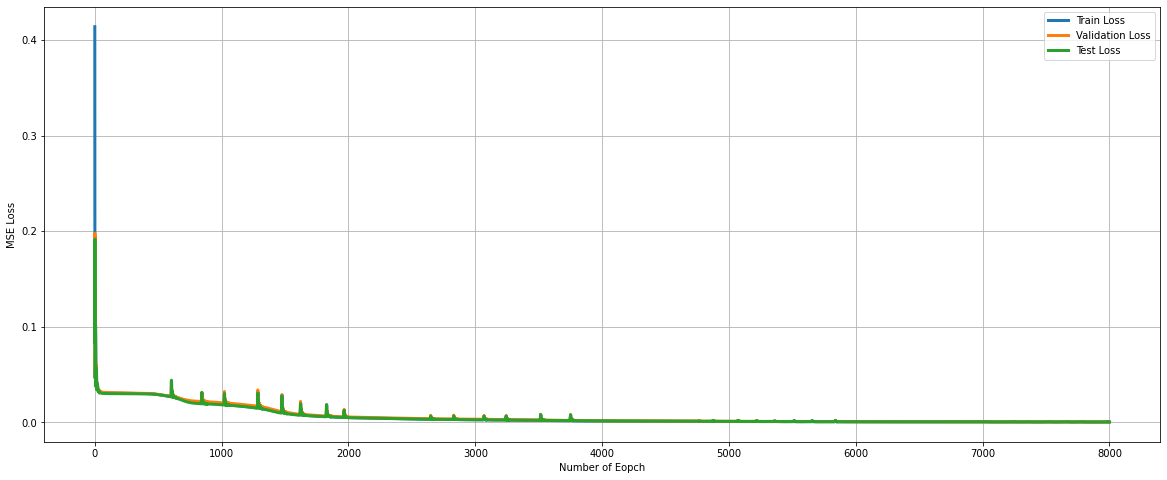

In [14]:
plot_result(train_losses, valid_losses, test_losses)

In [15]:
def visual_graph(model):
  x = np.linspace(-1, 1, 100)
  y = np.linspace(-1, 1, 100)
  xx,yy = np.meshgrid(x,y)
  xx = xx.reshape(-1,1)
  yy = yy.reshape(-1,1)
  inp_np = np.hstack((xx,yy))
  inp_tensor = torch.Tensor(inp_np)
  inp_tensor = inp_tensor.to(device)
  zz = model(inp_tensor)
  pred_output = zz.detach().cpu().numpy()
  fig = plt.figure(figsize=(9, 6))
  ax = fig.add_subplot(111, projection='3d')
  xx = xx.reshape(100,100)
  yy = yy.reshape(100,100)
  pred_output = pred_output.reshape(100,100)
  surf = ax.plot_surface(xx, yy, pred_output, cmap='viridis')
  surf.set_clim(-1.0, 1.0)
  ax.view_init(30,-60)
  ax.set_zticks([-1,1])
  ax.zaxis.set_major_locator(ticker.MultipleLocator(0.25))
  plt.tight_layout()
  plt.show()

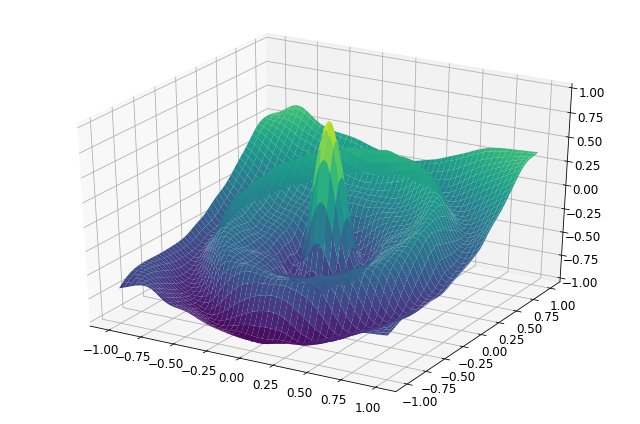

In [16]:
visual_graph(model)